In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta
import pickle
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
import os
from datetime import datetime, timedelta
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader/utility')
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader')
from XTBClient.api import XTBClient, PERIOD
from utility import utility 

In [4]:
def get_data_for_symbol(symbol):
    c = XTBClient()
    c.login(os.environ.get("XTB_user_num"), os.environ.get("XTB_pass"))
    df = c.get_candles_in_range(symbol, PERIOD.FIFTEEN_MINUTES.value, start=datetime.now() - timedelta(days=365))
    c.logout()
    
    df = df.reset_index()
    df.rename(columns={"timestamp": "date"}, inplace=True)
    
    df['date'] = df['date'].apply(pd.to_datetime)
    df.set_index('date',inplace=True)
    # df.drop([col for col in df.columns if col != "close"], axis=1, inplace=True)
    return df

In [5]:
def import_csv(name):
    df = pd.read_csv(name, sep=';')
    df.columns = ["date","open","high","low","close", "volume"]
    df.date = pd.to_datetime(df.date)
    df.drop(columns="volume", inplace=True)
    df.set_index('date', inplace=True, drop=True)
    return df

In [6]:
def save_model(model, filename):
    return pickle.dump(model, open(os.path.join("../", "models", "main_model.pkl"), 'wb'))

In [7]:
 
def load_model(filename):
    return pickle.load(open(os.path.join("../", "models", "main_model.pkl"), 'rb'))

In [8]:
def trend_accuracy(real, preds):
    df = pd.DataFrame({"real": real, "preds": preds})
    return len(df[df.real * df.preds > 0]) / len(df)

# Data import

In [9]:
# df = yf.download(tickers = 'EURUSD=x', period='1y', interval='15m')
df = get_data_for_symbol("EURUSD")
df.index.rename("Date", inplace=True)
df.rename(columns={col: col.lower() for col in df.columns}, inplace=True)
df.index.rename(df.index.name.lower(), inplace=True)
df

,open,close,high,low,volume
date,,,,,
2023-01-01 22:00:00,1.07058,1.06932,1.07086,1.06932,187.0
2023-01-01 22:15:00,1.06932,1.06933,1.06935,1.06906,102.0
2023-01-01 22:30:00,1.06931,1.06900,1.06936,1.06857,798.0
2023-01-01 22:45:00,1.06905,1.06944,1.06981,1.06895,1980.0
2023-01-01 23:00:00,1.06922,1.06777,1.06933,1.06773,285.0
...,...,...,...,...,...
2023-07-03 19:45:00,1.09110,1.09087,1.09110,1.09087,1710.0
2023-07-03 20:00:00,1.09086,1.09111,1.09115,1.09084,1885.0
2023-07-03 20:15:00,1.09112,1.09117,1.09117,1.09104,1078.0


In [10]:
df.ta.indicators(as_list=True);

# Additional Indicators

In [11]:
df['RSI']=ta.rsi(df.close, length=15)
df['EMAF']=ta.ema(df.close, length=20)
df['EMAM']=ta.ema(df.close, length=100)
df['EMAS']=ta.ema(df.close, length=150)
df['EMAS2']=ta.ema(df.close, length=120)


df['gain'] = df['close'].diff()
df['future_gain'] = df['gain'].shift(-1)
# df['future'] = df['close'].shift(1)
df = pd.concat([df, ta.stoch(df.high, df.low, df.close)], axis=1)

df.dropna(inplace=True)
df

,open,close,high,low,volume,RSI,EMAF,EMAM,EMAS,EMAS2,gain,future_gain,STOCHk_14_3_3,STOCHd_14_3_3
date,,,,,,,,,,,,,,
2023-01-03 11:15:00,1.05270,1.05261,1.05291,1.05191,12215.0,15.644104,1.057125,1.064082,1.066306,1.064679,-0.00010,0.00053,4.157572,3.550690
2023-01-03 11:30:00,1.05260,1.05314,1.05357,1.05251,10121.0,20.275578,1.056745,1.063865,1.066132,1.064489,0.00053,-0.00035,8.574807,5.260125
2023-01-03 11:45:00,1.05314,1.05279,1.05349,1.05263,11677.0,19.517384,1.056368,1.063646,1.065955,1.064295,-0.00035,0.00047,12.849630,8.527336
2023-01-03 12:00:00,1.05280,1.05326,1.05330,1.05237,12848.0,23.626454,1.056072,1.063440,1.065787,1.064113,0.00047,0.00069,19.409084,13.611174
2023-01-03 12:15:00,1.05324,1.05395,1.05397,1.05304,11486.0,29.303880,1.055870,1.063252,1.065630,1.063945,0.00069,0.00066,29.993749,20.750821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 19:30:00,1.09099,1.09110,1.09112,1.09099,941.0,52.322763,1.091076,1.090279,1.090053,1.090163,0.00012,-0.00023,20.216607,25.216498
2023-07-03 19:45:00,1.09110,1.09087,1.09110,1.09087,1710.0,48.816506,1.091056,1.090290,1.090064,1.090174,-0.00023,0.00024,16.059028,20.343106
2023-07-03 20:00:00,1.09086,1.09111,1.09115,1.09084,1885.0,52.383919,1.091061,1.090306,1.090077,1.090190,0.00024,0.00006,20.720721,18.998785


# Train Test split

In [12]:
# train, test = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]
train = df[df.index < df.index.min() + (df.index.max() - df.index.min()) * 0.8]
test = df[df.index >= df.index.min() + (df.index.max() - df.index.min()) * 0.8]

In [13]:
len(train), len(test)

(9847, 2475)

In [14]:
target = 'future_gain'
Y_train = train[target]
X_train = train.drop(target, axis=1)

Y_test = test[target]
X_test = test.drop(target, axis=1)

# Multivariable regression 

In [15]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [16]:
predictions = model.predict(X_test)

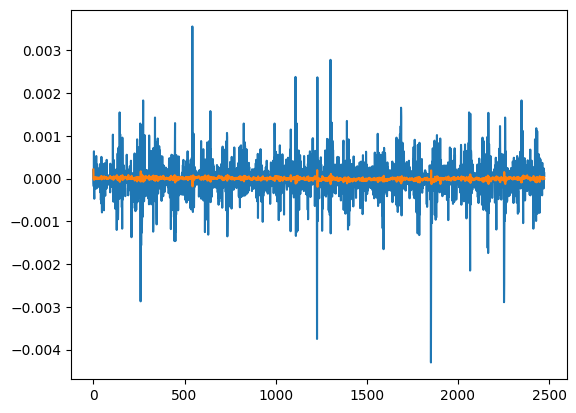

In [17]:
plt.plot(Y_test.values)
plt.plot(predictions)
plt.show()

In [18]:
rms = mean_squared_error(Y_test.values, predictions, squared=False)
rms

0.00044500996366680717

In [19]:
trend_accuracy(Y_test.values, predictions)

0.5183838383838384

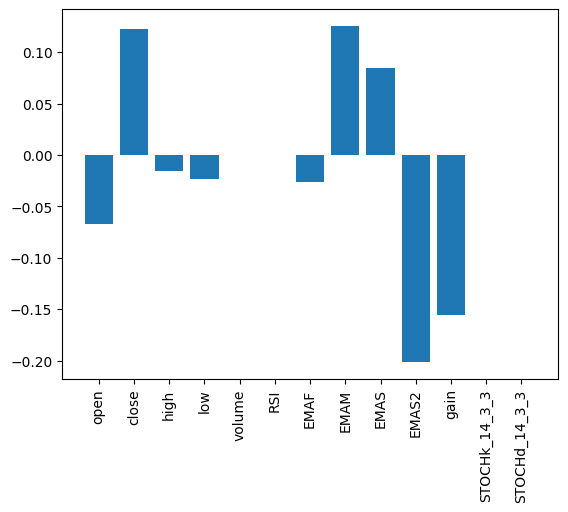

In [20]:
importance = model.coef_

plt.bar(model.feature_names_in_, importance )
plt.xticks(rotation='vertical');

# XGBoost

In [21]:
from numpy import loadtxt
from xgboost import XGBRegressor

In [22]:
model = XGBRegressor()

model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [23]:
predictions = model.predict(X_test)

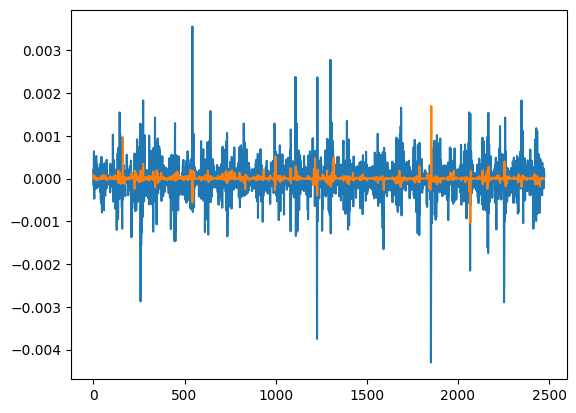

In [24]:
plt.plot(Y_test.values)
plt.plot(predictions)
plt.show()

In [25]:
rms = mean_squared_error(Y_test.values, predictions, squared=False)
rms

0.0004485219084186039

In [26]:
trend_accuracy(Y_test.values, predictions)

0.49373737373737375

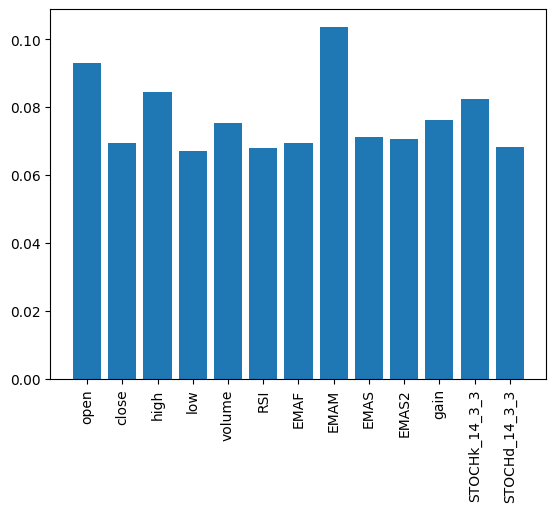

In [27]:
plt.bar(X_train.columns, model.feature_importances_)
plt.xticks(rotation='vertical')
plt.show()

# Catboost

In [28]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=5,
                          learning_rate=1,
                          depth=2)

model.fit(X_train, Y_train)

predictions = model.predict(X_test)

0:	learn: 0.0005668	total: 46.8ms	remaining: 187ms
1:	learn: 0.0005664	total: 48.5ms	remaining: 72.8ms
2:	learn: 0.0005650	total: 50ms	remaining: 33.3ms
3:	learn: 0.0005644	total: 51.6ms	remaining: 12.9ms
4:	learn: 0.0005641	total: 53.1ms	remaining: 0us


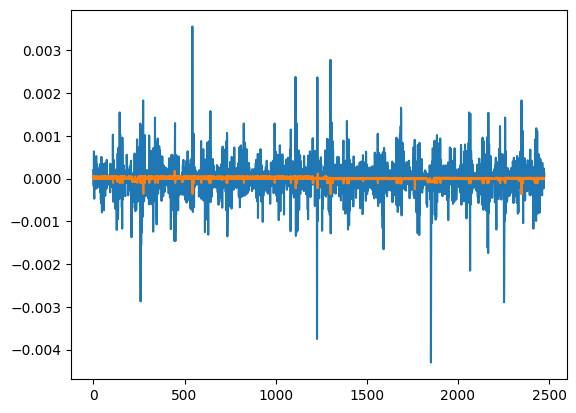

In [29]:
plt.plot(Y_test.values)
plt.plot(predictions)
plt.show()

In [30]:
rms = mean_squared_error(Y_test.values, predictions, squared=False)
rms

0.0004445114263589209

In [31]:
trend_accuracy(Y_test, predictions)

0.5022222222222222

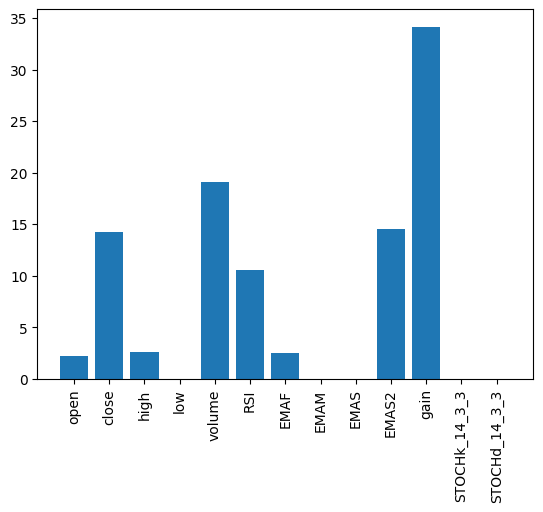

In [32]:
plt.bar(X_train.columns, model.feature_importances_)
plt.xticks(rotation='vertical')
plt.show()

# LSTM

In [45]:
data_set = df.iloc[:, 0:len(df.columns)]#.values

In [46]:
pd.set_option('display.max_columns', None)

In [47]:
data_set

,open,close,high,low,volume,RSI,EMAF,EMAM,EMAS,EMAS2,gain,future_gain,STOCHk_14_3_3,STOCHd_14_3_3
date,,,,,,,,,,,,,,
2023-01-03 11:15:00,1.05270,1.05261,1.05291,1.05191,12215.0,15.644104,1.057125,1.064082,1.066306,1.064679,-0.00010,0.00053,4.157572,3.550690
2023-01-03 11:30:00,1.05260,1.05314,1.05357,1.05251,10121.0,20.275578,1.056745,1.063865,1.066132,1.064489,0.00053,-0.00035,8.574807,5.260125
2023-01-03 11:45:00,1.05314,1.05279,1.05349,1.05263,11677.0,19.517384,1.056368,1.063646,1.065955,1.064295,-0.00035,0.00047,12.849630,8.527336
2023-01-03 12:00:00,1.05280,1.05326,1.05330,1.05237,12848.0,23.626454,1.056072,1.063440,1.065787,1.064113,0.00047,0.00069,19.409084,13.611174
2023-01-03 12:15:00,1.05324,1.05395,1.05397,1.05304,11486.0,29.303880,1.055870,1.063252,1.065630,1.063945,0.00069,0.00066,29.993749,20.750821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 19:30:00,1.09099,1.09110,1.09112,1.09099,941.0,52.322763,1.091076,1.090279,1.090053,1.090163,0.00012,-0.00023,20.216607,25.216498
2023-07-03 19:45:00,1.09110,1.09087,1.09110,1.09087,1710.0,48.816506,1.091056,1.090290,1.090064,1.090174,-0.00023,0.00024,16.059028,20.343106
2023-07-03 20:00:00,1.09086,1.09111,1.09115,1.09084,1885.0,52.383919,1.091061,1.090306,1.090077,1.090190,0.00024,0.00006,20.720721,18.998785


# Preparation for training

### MinMax Scaling

In [51]:
# sc = MinMaxScaler(feature_range=(0,1))
# data_set_scaled = sc.fit_transform(data_set)
data_set_scaled = np.array(data_set)
print(data_set_scaled)

[[ 1.05270000e+00  1.05261000e+00  1.05291000e+00 ...  5.30000000e-04
   4.15757241e+00  3.55068983e+00]
 [ 1.05260000e+00  1.05314000e+00  1.05357000e+00 ... -3.50000000e-04
   8.57480727e+00  5.26012536e+00]
 [ 1.05314000e+00  1.05279000e+00  1.05349000e+00 ...  4.70000000e-04
   1.28496297e+01  8.52733647e+00]
 ...
 [ 1.09086000e+00  1.09111000e+00  1.09115000e+00 ...  6.00000000e-05
   2.07207207e+01  1.89987852e+01]
 [ 1.09112000e+00  1.09117000e+00  1.09117000e+00 ...  1.50000000e-04
   2.79225672e+01  2.15674386e+01]
 [ 1.09116000e+00  1.09132000e+00  1.09133000e+00 ...  6.00000000e-05
   5.01804019e+01  3.29412299e+01]]


### BackCandles parameter

In [52]:
backcandles = 10 

In [53]:
X = []
print(data_set_scaled.shape[0])
for j in range(data_set_scaled.shape[1] - 3):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])


X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-3])
y=np.reshape(yi,(len(yi),1))

12322


# Train Test Split

In [54]:
splitlimit = int(len(X)*0.8)

X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print("Train length: {}\nTest length: {}\nRatio: {}".format(X_train.shape[0], X_test.shape[0], X_train.shape[0]/(X_train.shape[0] + X_test.shape[0])))

Train length: 9849
Test length: 2463
Ratio: 0.7999512670565302


# Model

In [55]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, data_set.shape[1]-3), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1);

Epoch 1/30


2023-07-03 23:01:15.804065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 23:01:15.805011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 23:01:15.805621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

584/591 [============================>.] - ETA: 0s - loss: 3.2325e-04

2023-07-03 23:01:19.153483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 23:01:19.154547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 23:01:19.155291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

591/591 [==============================] - 4s 4ms/step - loss: 3.1949e-04 - val_loss: 2.6833e-06
Epoch 2/30
591/591 [==============================] - 2s 4ms/step - loss: 3.7404e-06 - val_loss: 2.2415e-05
Epoch 3/30
591/591 [==============================] - 2s 4ms/step - loss: 5.5529e-06 - val_loss: 7.8675e-06
Epoch 4/30
591/591 [==============================] - 2s 4ms/step - loss: 3.0903e-06 - val_loss: 1.2999e-06
Epoch 5/30
591/591 [==============================] - 2s 4ms/step - loss: 6.2659e-06 - val_loss: 3.4887e-05
Epoch 6/30
591/591 [==============================] - 2s 4ms/step - loss: 1.0927e-05 - val_loss: 1.2932e-06
Epoch 7/30
591/591 [==============================] - 2s 4ms/step - loss: 1.7138e-06 - val_loss: 1.2139e-06
Epoch 8/30
591/591 [==============================] - 2s 4ms/step - loss: 2.6227e-06 - val_loss: 1.9255e-06
Epoch 9/30
591/591 [==============================] - 2s 4ms/step - loss: 1.7751e-06 - val_loss: 5.8612e-07
Epoch 10/30
591/591 [==================

# Evaluation

In [56]:
y_pred = model.predict(X_test)

25/77 [========>.....................] - ETA: 0s 

2023-07-03 23:02:28.991812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 23:02:28.992860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 23:02:28.993650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 0s 2ms/step


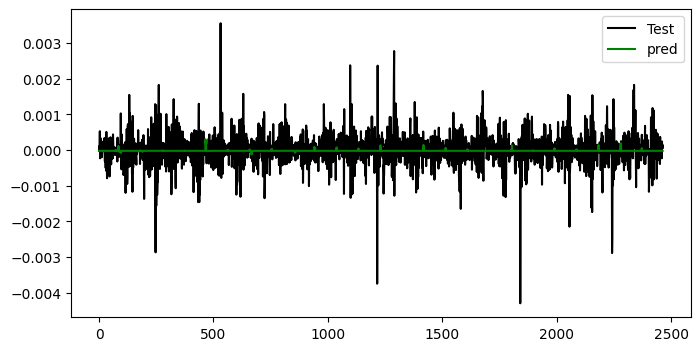

In [57]:
plt.figure(figsize=(8,4))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [59]:
rms = mean_squared_error(y_test, y_pred, squared=False)
rms

0.00044568121130601096